In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

In [2]:
%matplotlib inline

In [3]:
rcParams['figure.figsize'] = 12, 9

In [4]:
import astroimsim

In [5]:
zl = astroimsim.ZodiacalLight()

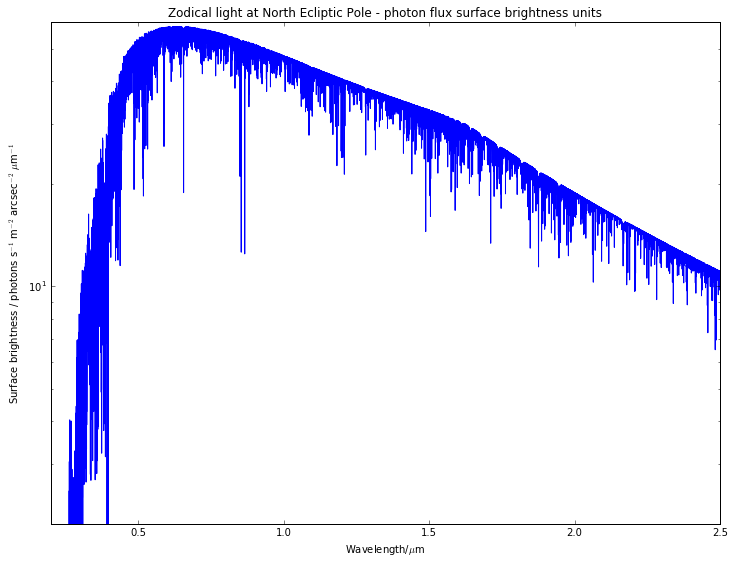

In [6]:
plt.semilogy(zl.waves, zl.photon_sfd, label='Zodical Light - NEP')
plt.xlim(0.2,2.5)
plt.ylim(2e-0,6e1)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Surface brightness / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ $\mu$m$^{-1}$')
plt.title('Zodical light at North Ecliptic Pole - photon flux surface brightness units');

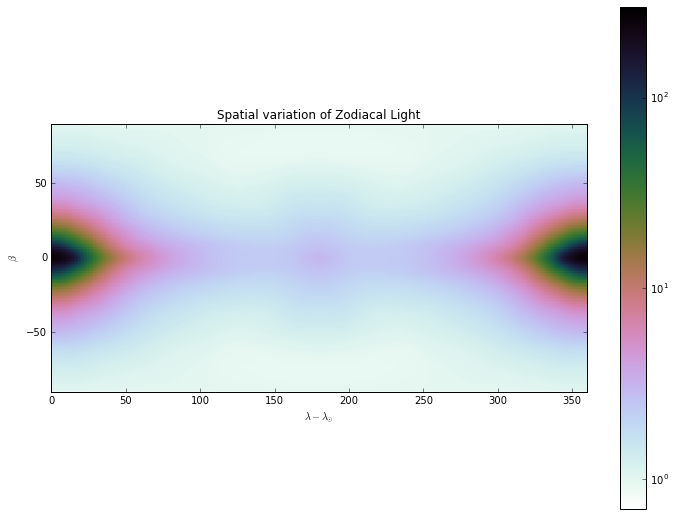

In [14]:
plt.imshow(zl.spatial(np.linspace(0,np.pi,180),np.linspace(0,2*np.pi,360)), \
           origin='lower', extent=[0,360,-90,90], norm=colors.LogNorm(vmin=0.7,vmax=300), \
           interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Spatial variation of Zodiacal Light')
plt.xlabel('$\lambda - \lambda_{\odot}$')
plt.ylabel('$\\beta$')